In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

In [4]:
from itertools import product, permutations, combinations
import numpy as np
import qutip as q
import matplotlib.pyplot as plt

from NVcenter import *

# plt.style.use("seaborn-v0_8")
plt.rcParams.update(
    {
        # "text.usetex": True,
        # "font.family": "serif",
        # "font.serif": ["Times"],  # used in elsarticle (Elsevier)
        # "font.serif": ["Computer Modern Roman"], # used in revtex4-2 (APS)
        # "text.latex.preamble": r"\usepackage{amsmath}\usepackage{siunitx}",
        "legend.fontsize": 20,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "axes.labelsize": 20,
        "axes.titlesize": 20,
        "font.size": 20,
    }
)

# Two Spin Systems

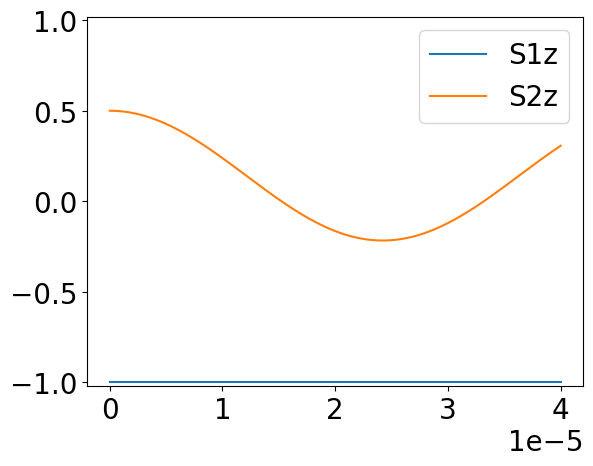

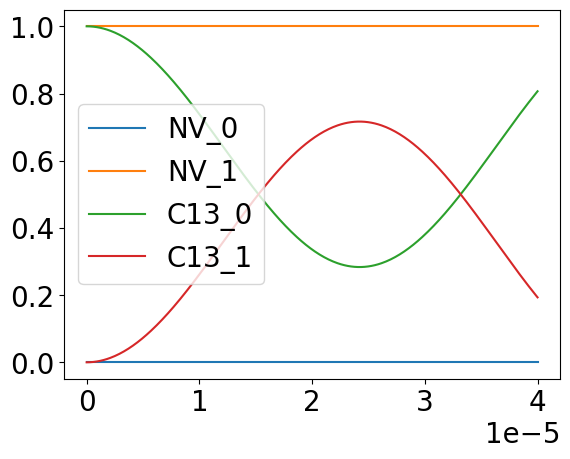

In [5]:
a_C = 3.567e-10
config_spin1 = ('NV', (0,0,0), 1, {})
# config_spin2 = ('N', (a_C/4)*3, 2, {}) # magnetic field in [111] direction
config_spin2 = ('N', (0,0,a_C), 2, {})
config_spin3 = ('C13', (0.87e-9, 0, 0.19e-9), 0, {})
config_spin4 = ('C13', (-1.3925181582438672e-09, -2.731479141248288e-09, 1.842277219043881e-09), 0, {}) # C-13 bath 
config_spin5 = ('P1', (-2.859443453078169e-10, -4.6234551830405316e-10, -5.025672803352349e-08), 0, {}) # P1 bath 
config_spin6 = ('C13', (5.596098242304543e-10, 7.693893562124301e-10, -3.0802088106455113e-10), 0, {})

times = np.linspace(0, 40e-6, 400)
observable_keys = ['S1z', 'S2z']

two_spin_config = TwoSpinSystem(config_spin1, config_spin6, times)
two_spin_config.plot_observables(observable_keys)
two_spin_config.plot_pops()

In [14]:
cartesian_to_spherical(-0.83e-9, 1.15e-9, 0.46e-9, degree=True)

(np.float64(1.4909728367747013e-09),
 np.float64(125.81945804237385),
 np.float64(72.02973412562616))

In [66]:
cartesian_to_spherical(0.87e-9, 0, 0.19e-9, degree=True)
# check ositions used by Dominik 
# (0.89, 0, 78) (0.87e-9, 0, 0.19e-9)
# (1e-9, 53.97, 107.94) (5.596098242304543e-10, 7.693893562124301e-10, -3.0802088106455113e-10)
# (1.5e-9, -53.97, -71.9) (-8.386525369132815e-10, 1.1530361110956996e-09, 4.660146444460976e-10)

(np.float64(8.905054744357274e-10),
 np.float64(0.0),
 np.float64(77.6805547433634))

In [30]:
# There are Rabi oscillation of the C-13 spin (since it has a vanishing y-coordinate)
# Idea: if NV center is in ms=-1, the C-13 flips after 28.36 us, if it is in ms=0, the C-13 is not affected > use this to create an entangled state
# We calculate the period of these oscillations

H_C13 = two_spin_config.H2
eps = H_C13[0,0] - H_C13[0,0]
delta = H_C13[0,1]
t = float(( np.pi/(2*np.sqrt(delta**2 + eps**2))).real) # 28.39 us

# Spin Baths

In [7]:
register_C13_pos = [(0.87e-9, 0, 0.19e-9)]
bath_spin_type = 'C13'
abundancy, rmin, rmax = 0.02e-2, 1.8e-9, 4.2e-9
spin_config = SpinConfig(register_C13_pos, bath_spin_type, abundancy, rmin, rmax, 
                     bath_spin_pos_seed=10, bath_init_state_idx=123, bath_P1_seed=123)

In [8]:
# Fig. 3 in Dominik's paper (binomial distribution)

a_C = 3.567e-10 # lattice constant for carbon
V_unit = a_C**3 # volume of the unit cell
N_unit = 8 # number of carbon atoms per unit cell
n = N_unit/V_unit # density of carbon atoms
volume = 4/3 * np.pi * 1.8e-9**3
N = n * volume

# Binomial distribution: abundancy is probability of finding a C-13 instead of a C-12
abundancies = np.arange(2, 11) * 0.005e-2
more_than_zero, more_than_one, more_than_two = [], [], []
for abundancy in abundancies: 
    zero_C13 = (1-abundancy)**N
    one_C13 = N * abundancy * (1-abundancy)**(N-1)
    two_C13 = N*(N-1)/2 * abundancy**2 * (1-abundancy)**(N-2)
    more_than_zero.append( 1- zero_C13 )
    more_than_one.append( 1- zero_C13 - one_C13 )
    more_than_two.append( 1- zero_C13 - one_C13 - two_C13 )

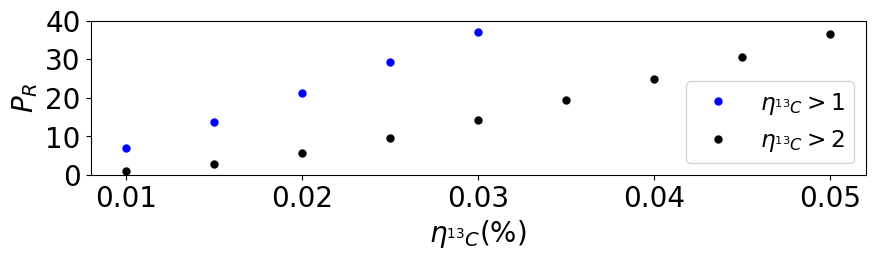

In [9]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(abundancies, more_than_one, 'b.', markersize=10, label=r'$\eta_{^{13}C}>1$')
ax.plot(abundancies, more_than_two, 'k.', markersize=10, label=r'$\eta_{^{13}C}>2$')
ax.set_ylabel(r'$P_R$')
ax.set_xlabel(r'$\eta_{^{13}C} (\%)$')
ax.set_ylim(0, 0.4)
# ax.set_xlim(0.01e-2, 0.05e-2)
ax.legend(fontsize='small')
ax.set_xticks([0.01e-2, 0.02e-2, 0.03e-2, 0.04e-2, 0.05e-2], [0.01, 0.02, 0.03, 0.04, 0.05])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4], [0, 10, 20, 30, 40])
plt.show()

# Benchmarking

In [48]:
register_C13_pos = [(0.87e-9, 0, 0.19e-9)]#, (5.596098242304543e-10, 7.693893562124301e-10, -3.0802088106455113e-10), (-8.386525369132815e-10, 1.1530361110956996e-09, 4.660146444460976e-10)]
bath_spin_type = 'C13'
abundancy, rmin, rmax = 0.02e-2, 2e-9, 4.2e-9

bath_spin_type = 'P1'
abundancy, rmin, rmax = 26e-9, 30e-9, 80e-9

bath_approx_level = 'no_bath'

# sample over bath configurations 
spin_config = SpinConfig(register_C13_pos, bath_spin_type, abundancy, rmin, rmax, 
                     bath_spin_pos_seed=10, bath_init_state_idx=123, bath_P1_seed=123)

In [49]:
system_configs, mf_configs = spin_config.system_configs[bath_approx_level], spin_config.mf_configs[bath_approx_level]

system = System(system_configs, mf_configs)
system.H

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-2.37692308e+05+0.00000000e+00j  1.60171588e+00+6.12117982e-01j
   4.37902407e+00+8.29185756e+00j -1.00270443e+01-5.92525010e+00j
   3.64182543e+00+8.26456006e+00j -1.47617731e+00-3.68220306e+00j
   4.28632471e+01-4.11894407e+01j  0.00000000e+00+0.00000000e+00j
   5.51091807e+04-4.09439385e+04j -1.13963105e+04+3.43364216e+04j
  -3.67747261e+04-1.13550031e+05j  0.00000000e+00+0.00000000e+00j
   1.79123802e+05+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 1.60171588e+00-6.12117982e-01j -7.92248775e+04+0.00000000e+00j
  -3.79816534e+00+0.00000000e+00j  2.04010955e+00+7.65244208e+00j
  -1.27659123e+00+0.00000000e+00j  2.77730819e+00+7.67973957e+00j
   0.00000000e+00+0.00000000e+00j  4.28632471e+01-4.11894407e+01j
   9.52210665e+03+0.00000000e+00j  6.88437494e+04-2.19141145e+04j
   0.00000000e+00+0.0000

In [50]:
pulse_seq = [0e-6, 4.06e-6, 1.57e-6, 1.51e-6, 1.00, 3.58, 1.68, 0.69, 1.97, 0.50]
target_state = 1/np.sqrt(2) * (q.tensor(q.fock_dm(2,0), q.fock_dm(2,0)) + q.tensor(q.fock_dm(2,1), q.fock_dm(2,1)) )

pulses = Pulses(spin_config, pulse_seq, target_state, bath_approx_level)
pulses.final_fidelity

TypeError: incompatible dimensions [[2, 2], [2, 2]] and [[2, 2, 2, 2], [2, 2, 2, 2]]

9 bath spins
fixed positions

C13: 2**9=512 (all spin states)
P1: 1050 (spin states and lamor disorders)

In [7]:
# This section is meant to produce the plots from IV.A.

# parameters
register_C13_pos = [(0.87e-9, 0, 0.19e-9)] #, (0.56e-9, 0.77e-9, 0.31e-9), (-0.83e-9, 1.15e-9, 0.46e-9)]
bath_spin_type = 'C13'
abundancy, rmin, rmax = 0.02e-2, 2e-9, 4.2e-9

bath_spin_type = 'P1'
abundancy, rmin, rmax = 26e-9, 30e-9, 80e-9

pulse_seq = [0e-6, 4.06e-6, 1.57e-6, 1.51e-6, 1.00, 3.58, 1.68, 0.69, 1.97, 0.50]
target_state = 1/np.sqrt(2) * (q.tensor(q.fock_dm(2,0), q.fock_dm(2,0)) + q.tensor(q.fock_dm(2,1), q.fock_dm(2,1)) )

In [8]:

# sample over bath configurations 
spin_config = SpinConfig(register_C13_pos, bath_spin_type, abundancy, rmin, rmax, 
                     bath_spin_pos_seed=10, bath_init_state_idx=123, bath_P1_seed=123)

# result = {}
# times = np.linspace(0, 40e-6, 100)
# for bath_approx_level in ['no_bath']: # spin_config.bath_approx_levels:
#     pulses = Pulses(spin_config, pulse_seq, target_state, bath_approx_level)
#     result[bath_approx_level] = pulses.calc_state_evo(times)
# result

# final_fidelities = {}
# for bath_approx_level in spin_config.bath_approx_levels:
#     pulses = Pulses(spin_config, pulse_seq, target_state, bath_approx_level)
#     final_fidelities[bath_approx_level] = pulses.final_fidelity
# final_fidelities

In [ ]:
# plotting
# input: result (list of time evolution of the density matrix)

fig, ax = plt.subplots()
ax.plot(times, [q.expect(dm, Sz) for dm  in result], label=r'$\langle S_z \rangle$')
ax.plot(times, [q.expect(dm, Ix) for dm  in result], label=r'$\langle I_x \rangle$')
ax.plot(times, [q.expect(dm, Iz) for dm  in result], label=r'$\langle I_z \rangle$')
ax.axvline(x=pulses.pulse_time)
ax.set_xlabel(r'$t\,(\mu s)$')
ax.legend()

plt.show()

# Optimization

In [73]:
# Optimize pulse sequence 
from scipy.optimize import basinhopping, Bounds

def print_progress(x, f, accepted):
    print(f"Current parameters: {x}, Infidelity: {f}, Accepted: {accepted}")

register_C13_pos = [(0.87e-9, 0, 0.19e-9)] #, (0.56e-9, 0.77e-9, 0.31e-9), (-0.83e-9, 1.15e-9, 0.46e-9)]
bath_spin_type = 'C13'
abundancy, rmin, rmax = 0.02e-2, 2e-9, 4.2e-9
target_state = 1/np.sqrt(2) * (q.tensor(q.fock_dm(2,0), q.fock_dm(2,0)) + q.tensor(q.fock_dm(2,1), q.fock_dm(2,1)) )
init_pulse_seq = [0e-6, 4.06e-6, 1.57e-6, 1.51e-6, 1.00, 3.58, 1.68, 0.69, 1.97, 0.50]

spin_config = SpinConfig(register_C13_pos, bath_spin_type, abundancy, rmin, rmax)
system_configs = spin_config.system_configs['no_bath']

def calc_infidelity(pulse_seq):
    system = System(system_configs, [])
    pulses = Pulses(system, pulse_seq, target_state)
    return 1 - pulses.final_fidelity

basinhopping(
    calc_infidelity, init_pulse_seq, 
    minimizer_kwargs={"method": "L-BFGS-B", "bounds": Bounds([0]*10, [10e-6]*4+[np.pi]*3+[2*np.pi]*3) },
    callback=print_progress, niter=10,
)

Current parameters: [9.99999405e-06 0.00000000e+00 1.00000000e-05 9.99999319e-06
 9.19045165e-01 2.97811469e+00 1.93253932e+00 3.49778016e-01
 2.65039711e+00 1.59806553e-01], Infidelity: 0.404715831921026, Accepted: True
Current parameters: [0.00000000e+00 0.00000000e+00 1.00000000e-05 8.93599882e-07
 3.10514285e-01 2.74049343e+00 2.32354085e+00 4.44929279e-01
 2.64857402e+00 3.86220085e-01], Infidelity: 0.44209083512606695, Accepted: True
Current parameters: [0.00000000e+00 5.89371536e-09 9.99804467e-06 8.88810893e-07
 9.63320968e-01 2.53603199e+00 1.97282642e+00 6.45455220e-02
 3.07658758e+00 6.87244893e-01], Infidelity: 0.41737566731106757, Accepted: False
Current parameters: [9.06692445e-06 9.33075547e-07 9.06692445e-06 1.00000000e-05
 3.23441408e-01 2.61100751e+00 1.57457545e+00 2.12374150e-03
 3.22388891e+00 2.68083543e-01], Infidelity: 0.377317283102641, Accepted: False
Current parameters: [1.00000000e-05 1.00000000e-05 6.44741891e-27 0.00000000e+00
 0.00000000e+00 2.62039845e+0

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.29308495105400767
                          x: [ 2.610e-20  2.610e-20  0.000e+00  1.000e-05
                               0.000e+00  2.289e+00  2.279e+00  2.614e-01
                               3.092e+00  0.000e+00]
                        nit: 10
      minimization_failures: 5
                       nfev: 5764
                       njev: 524
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.29308495105400767
                                    x: [ 2.610e-20  2.610e-20  0.000e+00
                                         1.000e-05  0.000e+00  2.289e+00
                                         2.279e+00  2.614e-01  3.092e+00
                                    